In [1]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pickle

import sys
sys.path.append("/user/tlm2160/cap6_tm/")

# Force reload of modules to get latest changes
import importlib
from src.tree import TreeModel
from src.climate import BPWClimate
from src.emit_baseline import BPWEmissionBaseline
from src.damage import BPWDamage
from src.tools import import_csv
from src.analysis import output_unpacker, tree_diagrams

# Reload modules to get latest code changes
importlib.reload(output_unpacker)
importlib.reload(tree_diagrams)

from src.analysis.output_unpacker import OutputUnpacker
from src.analysis.tree_diagrams import TreeDiagram

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 16, 10
params = {'legend.fontsize': 14,
          'legend.frameon': True,
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 18,
         'ytick.labelsize': 18,
         'font.family': 'serif'}
mpl.rcParams.update(params)

# Change to project directory and ensure plots folder exists
os.chdir('/user/tlm2160/cap6_tm/')
if not os.path.exists('plots'):
    os.makedirs('plots')

base_dir = "plots/"

today = datetime.datetime.now()
year = str(today.year)
day = str(today.day)
month = str(today.month)

basefile = ''.join([month, '-', day, '-', year, '-'])

In [2]:
# Define the runs to analyze
# Available: delay1, delay2, delay3 (different delay lengths)
# Using delay1 as default
delay_scenario = 'delayed'

prefix_list = [
    f'optimal/pref-run_delay10yr_optimal',
    f'delayed/pref-run_delay5yr_{delay_scenario}',
    f'delayed/pref-run_delay10yr_{delay_scenario}',
    f'delayed/pref-run_delay15yr_{delay_scenario}',
]

path_list = [
    'data/single-period-canonical-baseline/',
]

descriptions = [
    f'Optimal Policy (no delay)',
    f'Delayed Policy 5yr',
    f'Delayed Policy 10yr',
    f'Delayed Policy 15yr',
]

decision_times_list = [
    [0, 10, 40, 70, 110, 160, 210],
    [0, 5, 40, 70, 110, 160, 210],
    [0, 10, 40, 70, 110, 160, 210],
    [0, 15, 40, 70, 110, 160, 210]
]

output_list = []
picklefile_list = []

N_files = len(prefix_list)
for path in path_list:
    for file in range(0, N_files):
        tmp_filename = path + prefix_list[file] + "_node_period_output.csv"
        tmp_picklefile_name = path + prefix_list[file] + "_log.pickle"
        output_list.append(tmp_filename)
        picklefile_list.append(tmp_picklefile_name)

In [3]:
data_csv_file = 'research_runs'
header, indices, data = import_csv(data_csv_file, delimiter=',', indices=2)
done_runs = [0]

models = {}

for counter, times in enumerate(decision_times_list):
    tree_list = []
    damage_list = []
    climate_list = []
    emit_baseline_list = []
    for i in done_runs:
        ra, eis, pref, growth, tech_chg, tech_scale, dam_func,\
                baseline_num, tip_on, bs_premium, d_unc, t_unc, nfl = data[i]

        baseline_num = int(baseline_num)
        dam_func = int(dam_func)
        tip_on = int(tip_on)
        d_unc = int(d_unc)
        t_unc = int(t_unc)
        nfl = int(nfl)

        tmp_tree = TreeModel(decision_times=times,
                    prob_scale=1.0)

        """Emission baseline model. We also run its setup function.
        """

        tmp_baseline_emission_model = BPWEmissionBaseline(tree=tmp_tree,
                                                    baseline_num=baseline_num)
        tmp_baseline_emission_model.baseline_emission_setup()

        """Climate class. We set draws to the number of Monte Carlo samples to take
        from damage distributions, such as TCRE, and if the floor is on.
        """

        draws = 3 * 10**6
        tmp_climate = BPWClimate(tmp_tree, tmp_baseline_emission_model, draws=draws)

        """Damage class. We set draws to the number of Monte Carlo samples to take
        from damage distributions, such as TCRE. We also pass a list of constant
        values of mitigation for the damage simulation.
        
        NOTE: We don't need to import the full damage simulation for visualization.
        The d_rcomb (recombined damage) values will be loaded from the pickle file
        in the next cell.
        """

        d_m = 0.1
        mitigation_constants = np.arange(0, 1 + d_m, d_m)[::-1]
        tmp_df = BPWDamage(tree=tmp_tree, emit_baseline=tmp_baseline_emission_model,
                    climate=tmp_climate, mitigation_constants=mitigation_constants,
                    draws=draws)

        # Skip damage import - we'll load d_rcomb from pickle file instead
        
        tree_list.append(tmp_tree)
        emit_baseline_list.append(tmp_baseline_emission_model)
        climate_list.append(tmp_climate)
        damage_list.append(tmp_df)
    
    models[counter] = {
        'tree': tree_list[0],
        'emit_baseline': emit_baseline_list[0],
        'climate': climate_list[0],
        'damage': damage_list[0]
    }

    print(f"Model instances created for run 0")
    print(f"Tree has {tmp_tree.num_decision_nodes} decision nodes")
    print(f"Decision times: {tmp_tree.decision_times}")
    print(f"Corresponding years: {[2020 + dt for dt in tmp_tree.decision_times]}")
    print(f"Note: d_rcomb will be loaded from pickle files in next cell")

Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0  10  40  70 110 160 210]
Corresponding years: [2020, 2030, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell
Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0   5  40  70 110 160 210]
Corresponding years: [2020, 2025, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell
Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0  10  40  70 110 160 210]
Corresponding years: [2020, 2030, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell
Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0  15  40  70 110 160 210]
Corresponding years: [2020, 2035, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell


In [4]:
output_obj_list = []
pickle_obj_list = []

for counter in range(len(models)):

    with open(picklefile_list[counter], 'rb') as f:
        pickle_data = pickle.load(f)
    
    if 'df.d_rcomb' in pickle_data:
        models[counter]['damage'].d_rcomb = pickle_data['df.d_rcomb']
    print(output_list[counter])
    tmp_output_obj = OutputUnpacker(output_list[counter], descriptions, 'output', 
                                    tree=models[counter]['tree'], 
                                    emit_baseline=models[counter]['emit_baseline'],
                                    climate=models[counter]['climate'], 
                                    damage=models[counter]['damage'])
    output_obj_list.append(tmp_output_obj)
    
    tmp_pickle_obj = OutputUnpacker(picklefile_list[counter], descriptions, 'pickle',
                                    tree=models[counter]['tree'], 
                                    emit_baseline=models[counter]['emit_baseline'],
                                    climate=models[counter]['climate'], 
                                    damage=models[counter]['damage'])
    pickle_obj_list.append(tmp_pickle_obj)

data/single-period-canonical-baseline/optimal/pref-run_delay10yr_optimal_node_period_output.csv
data/single-period-canonical-baseline/delayed/pref-run_delay5yr_delayed_node_period_output.csv
data/single-period-canonical-baseline/delayed/pref-run_delay10yr_delayed_node_period_output.csv
data/single-period-canonical-baseline/delayed/pref-run_delay15yr_delayed_node_period_output.csv


In [5]:
# Set to True to save figures
save_fig = False
tree_runs = range(N_files)

## Tree Diagrams: Carbon Prices (Enhanced Spaced Version)

Using the new TreeDiagramSpaced class with flexible spacing options.

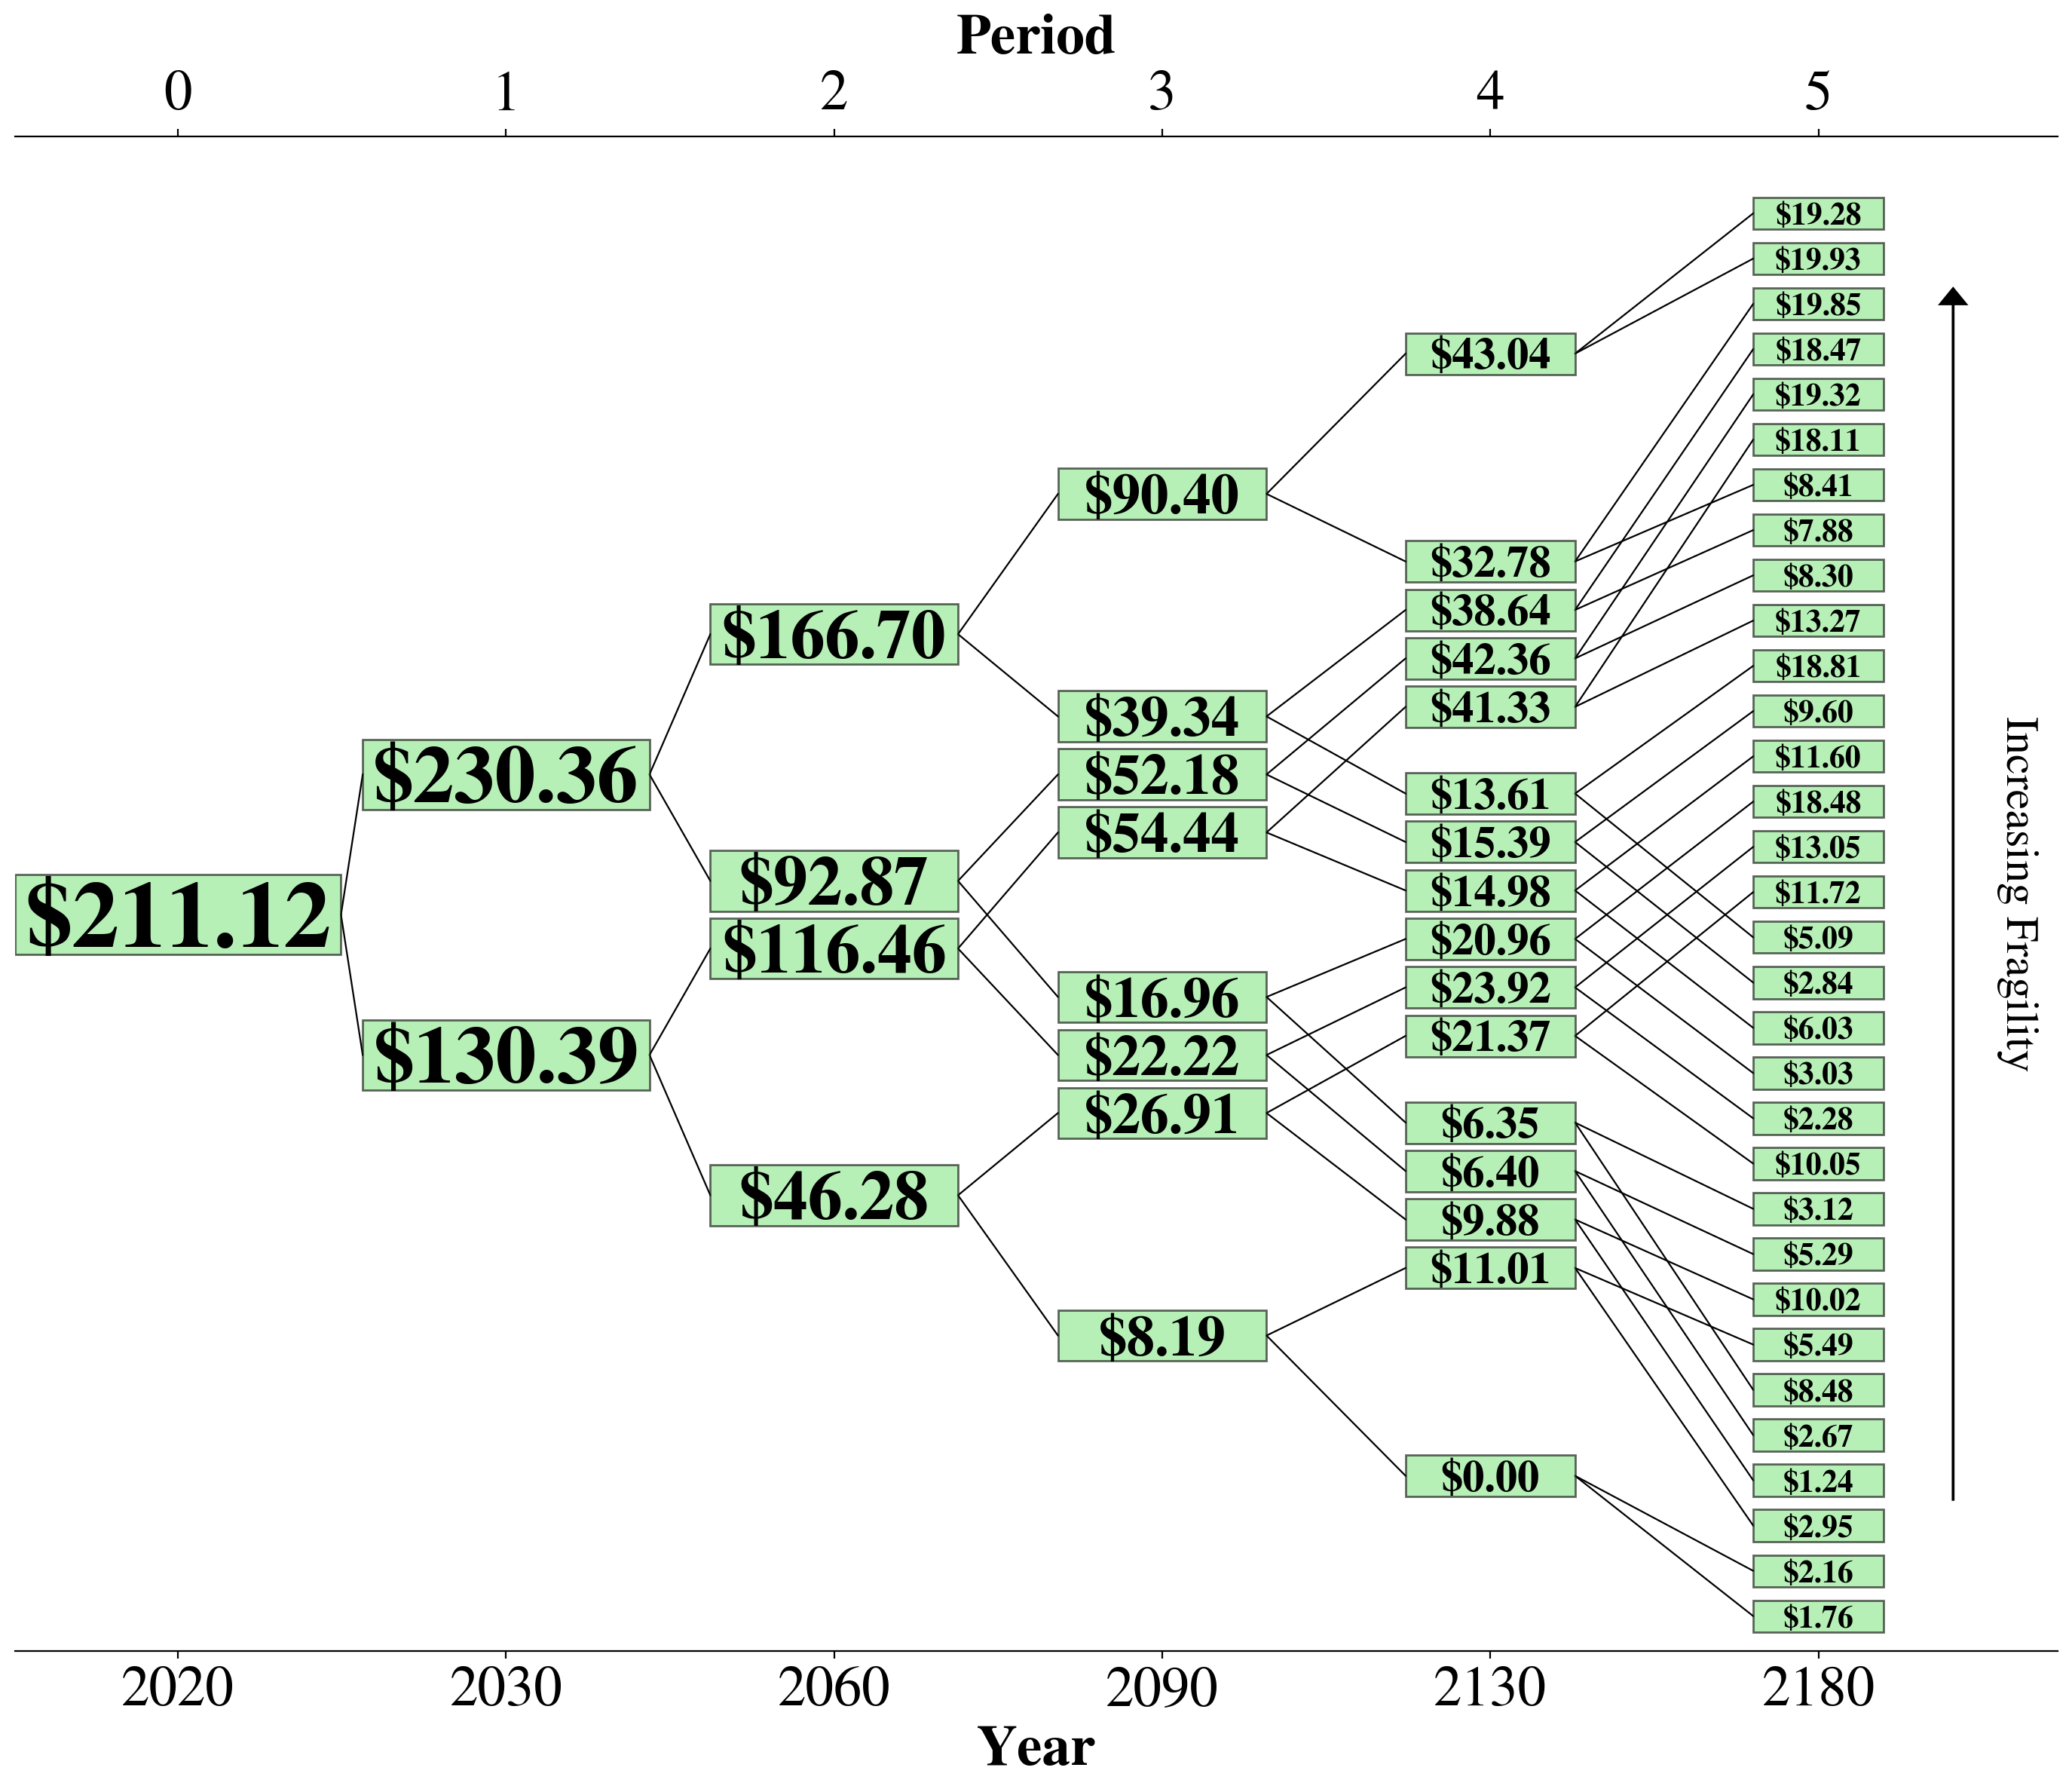

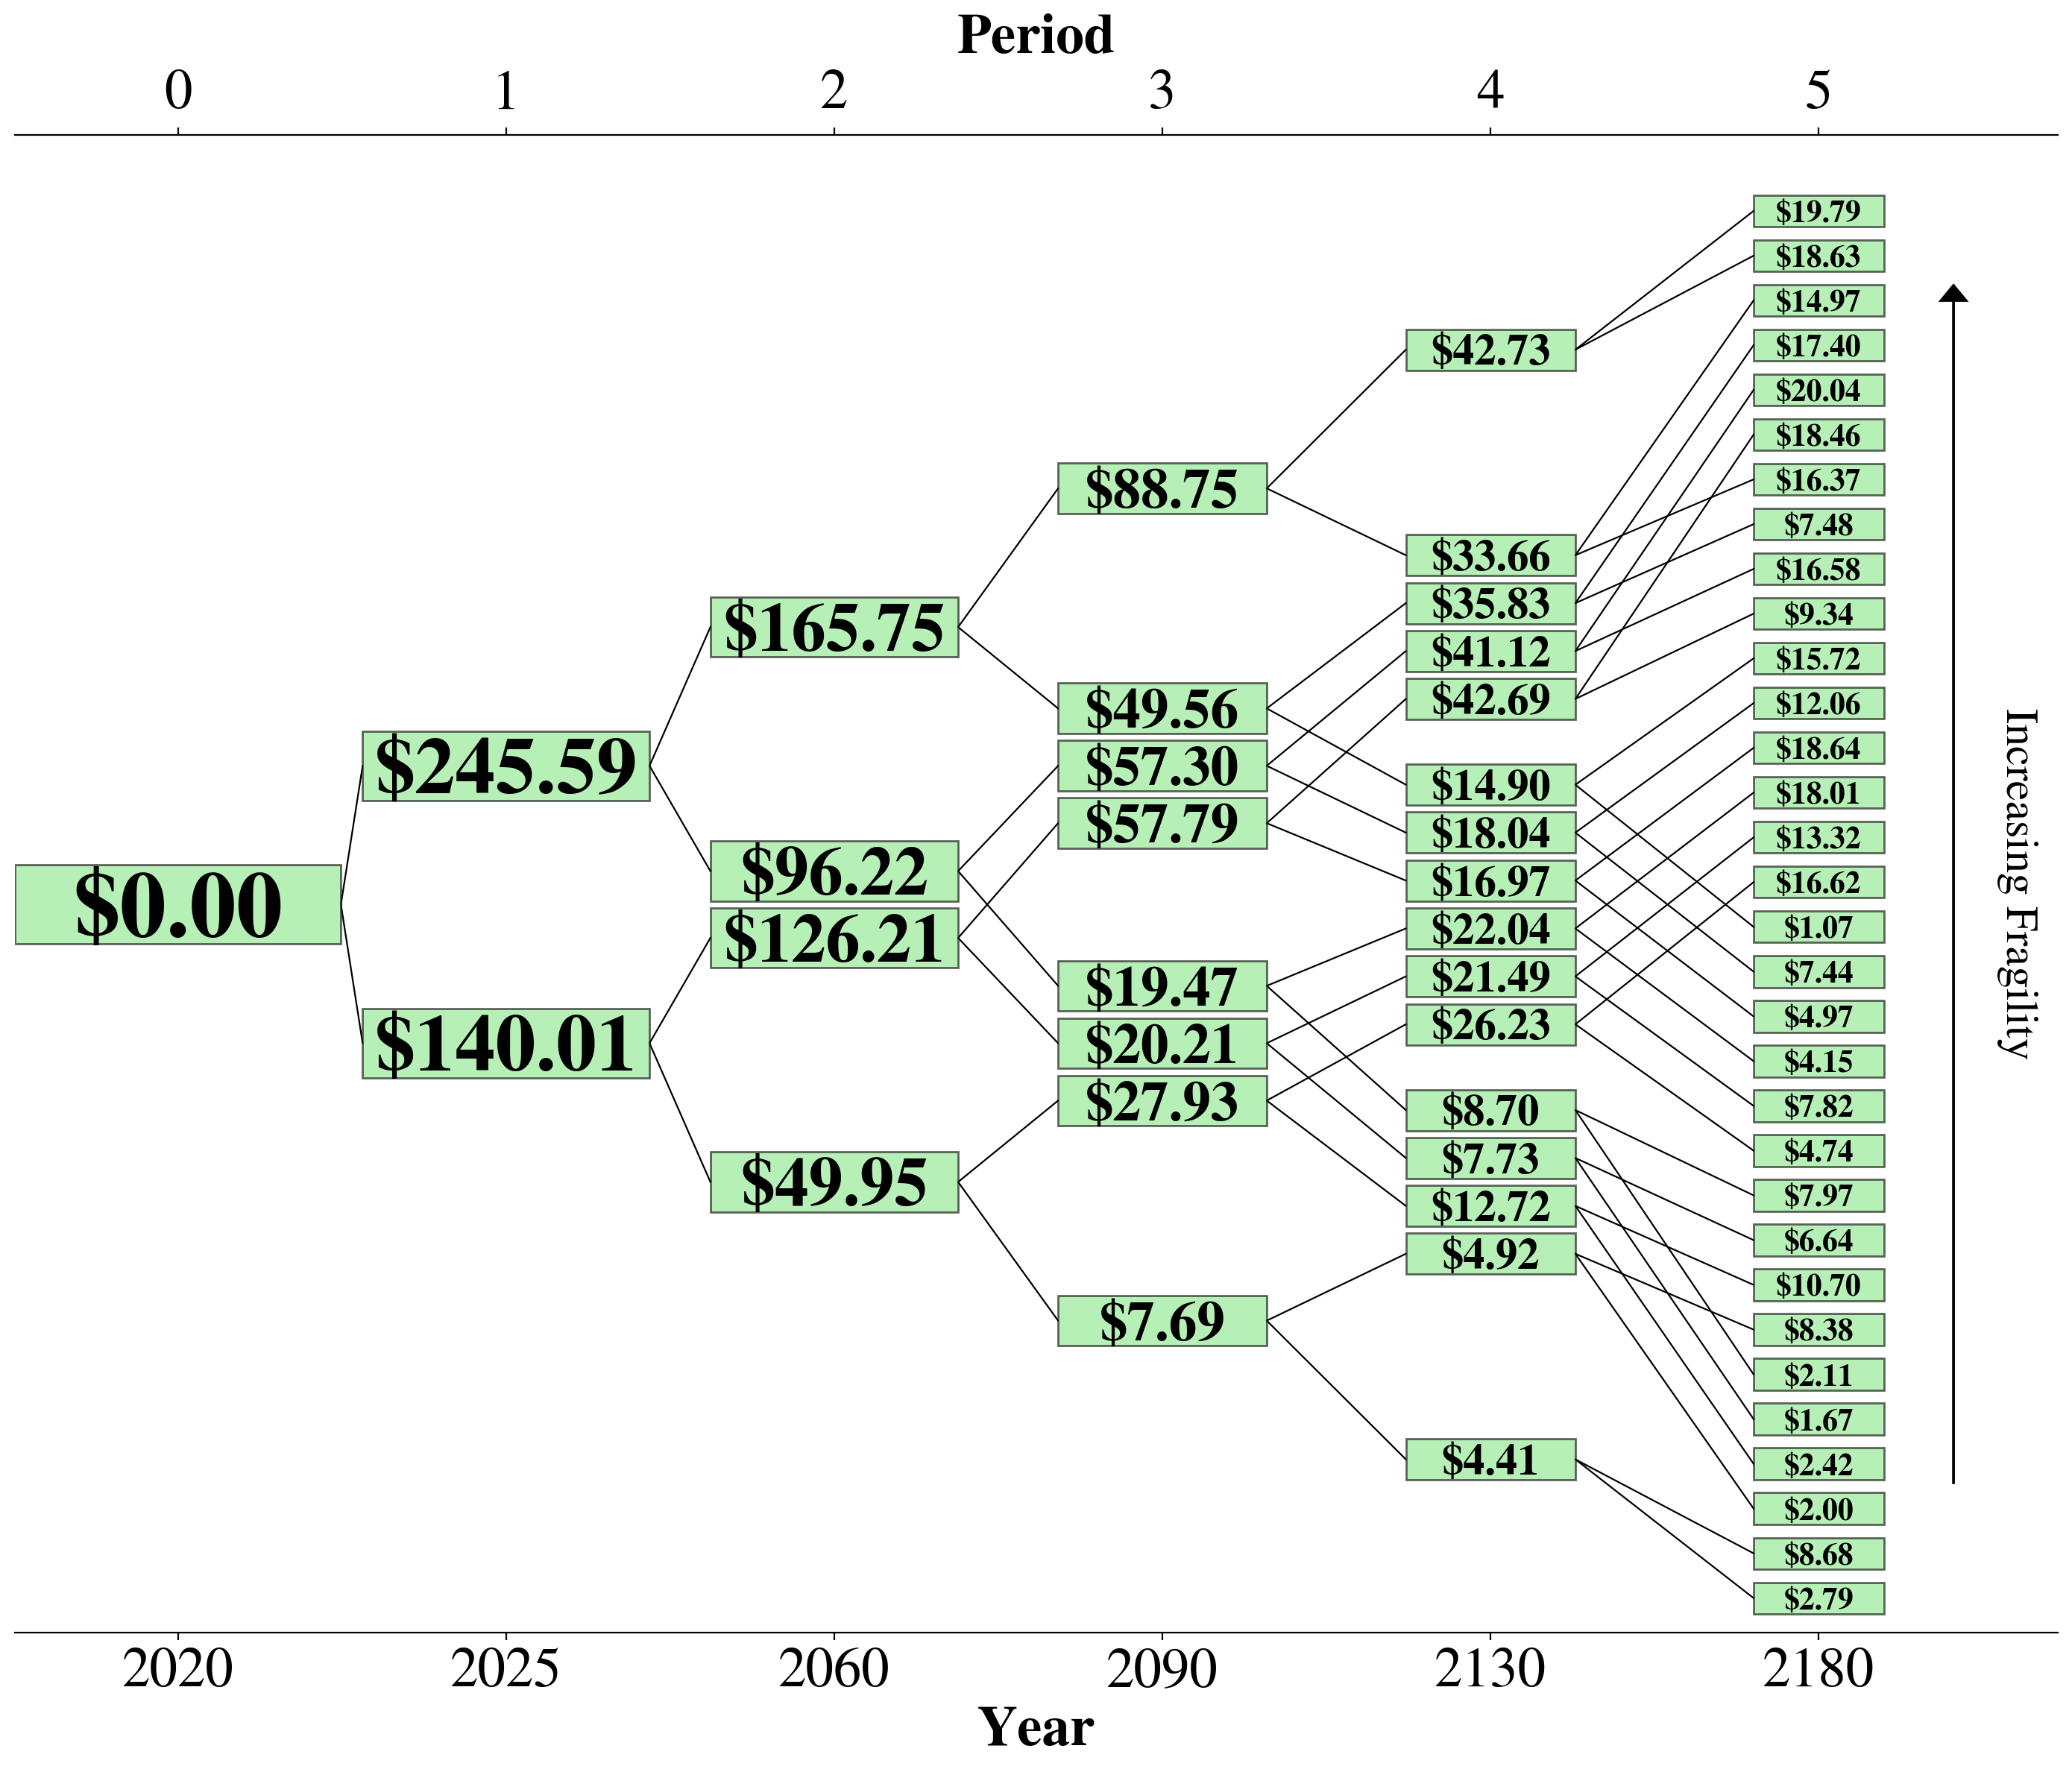

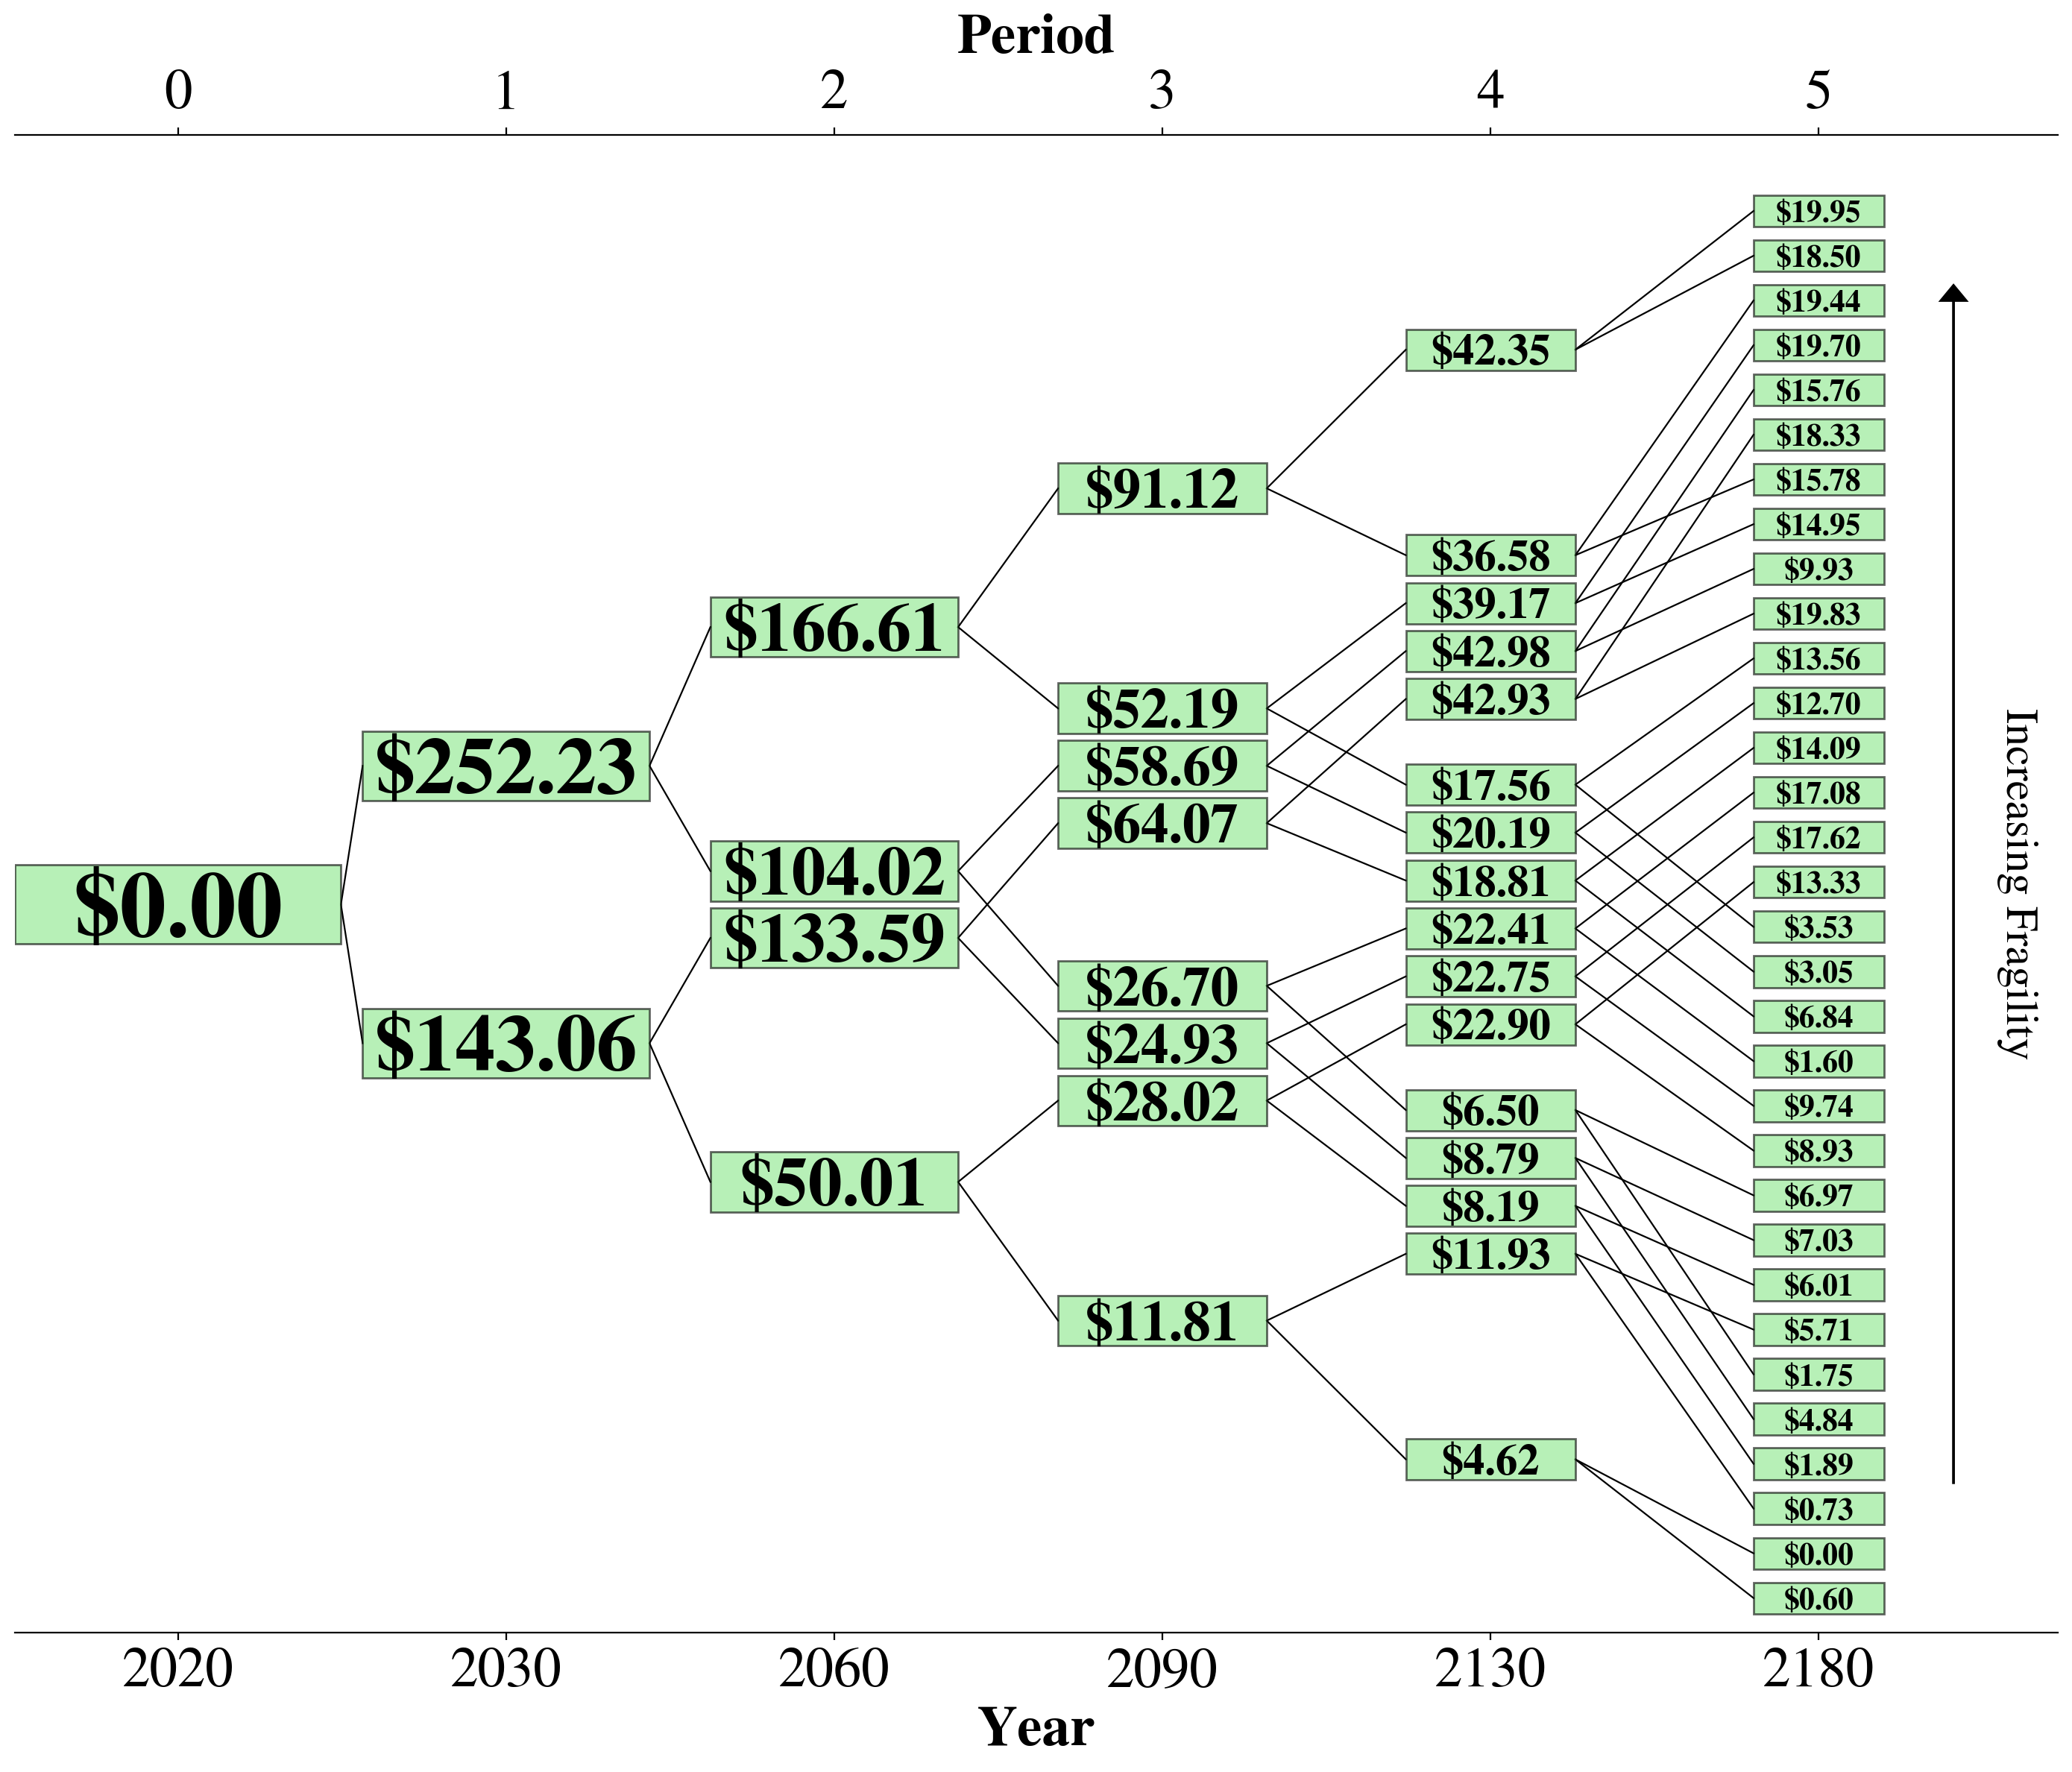

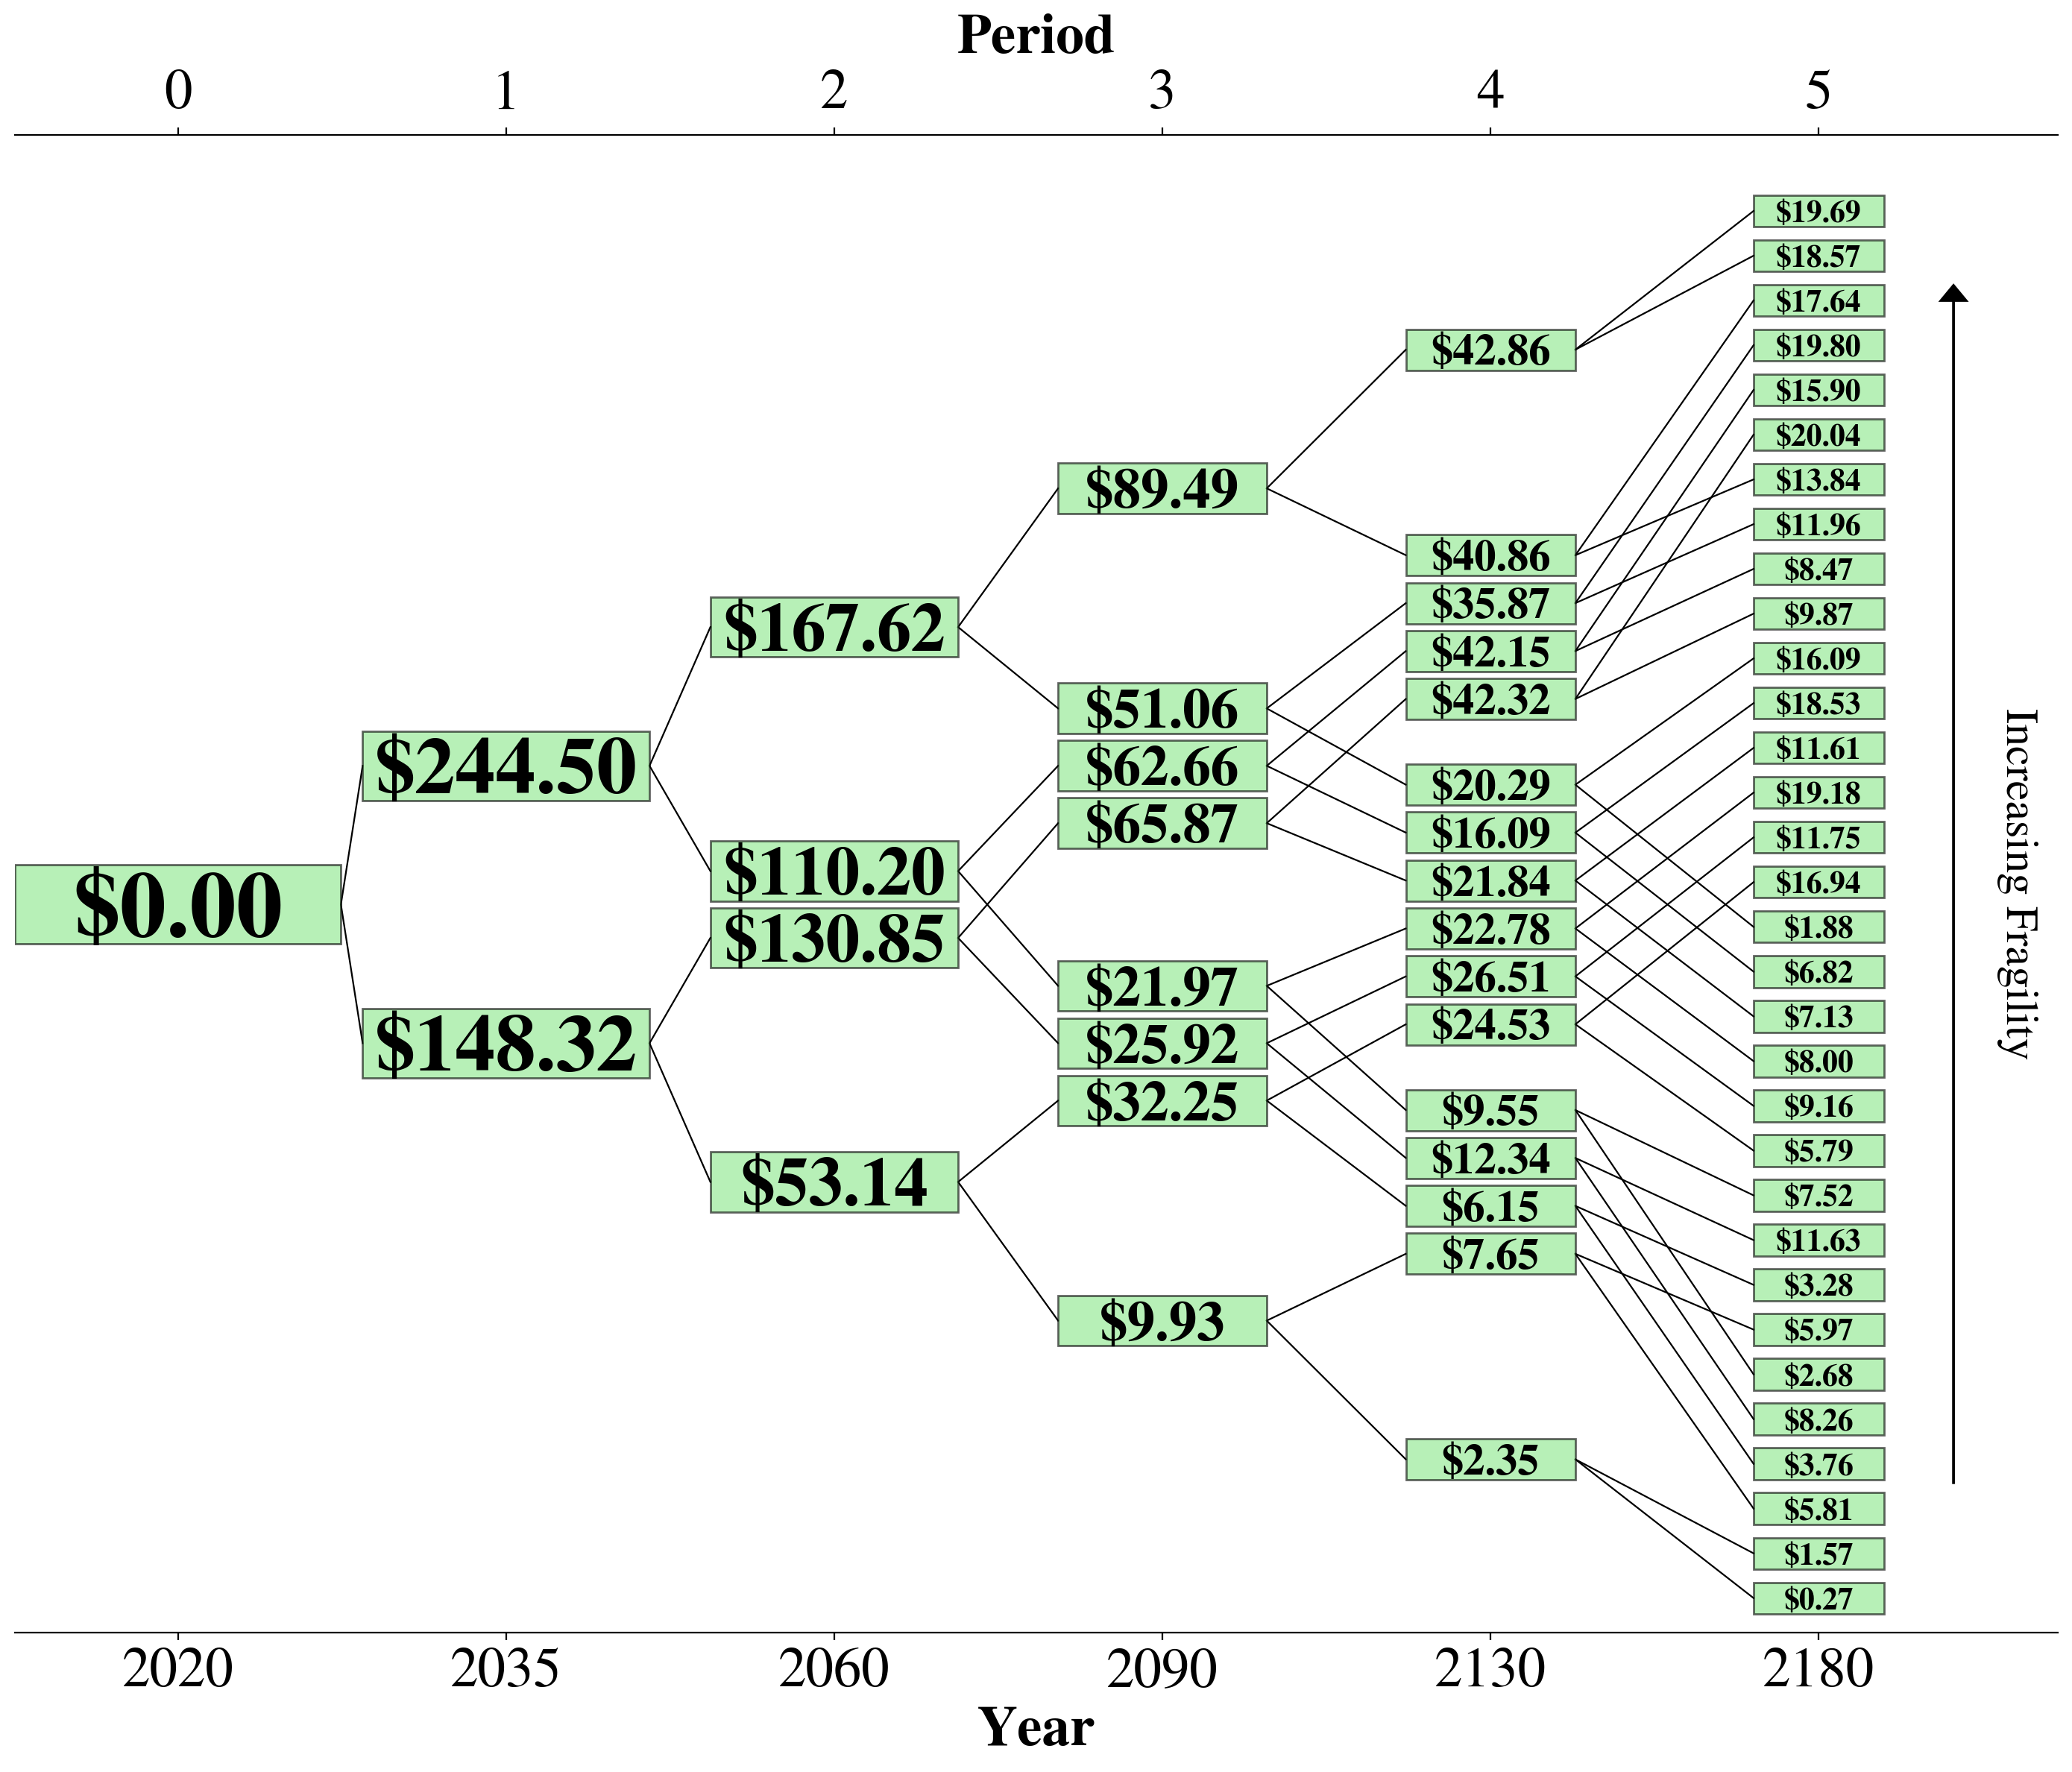

In [66]:
# Import and reload the new TreeDiagramSpaced class
import importlib
from src.analysis import tree_diagrams_spaced
importlib.reload(tree_diagrams_spaced)
from src.analysis.tree_diagrams_spaced import TreeDiagramSpaced

for file in tree_runs:
    tmp_Tree = TreeDiagramSpaced(
        N_periods=6, 
        data=output_obj_list[file].price_node, 
        path_notation=False, 
        save_fig=True, 
        is_cost=True, 
        decision_times=decision_times_list[file], 
        figsize=(14, 12),
        box_scale_mode='progressive',
        font_scale_mode='progressive',
        fig_name=base_dir + basefile + prefix_list[file].split("/")[1] + '_tree_diagram_temp',
        spacing_multiplier=1.1,
        even_spacing_last_period=True
    )
    tmp_Tree.makePlot(show_fragility_arrow=True)
    plt.show()